# Classification models - supervised discretization

Dataset: musk <br>
By: Sam <br>
Update at: 15/03/2023 <br>

====

Summary:<br>
- Import unsupervised discretised datasets (already encoded categorical attributes)
- Split dataset: 75% training, 25% testing, seed = 30
- Class imbalance: Using SMOTE-Tomek for training data
- Perform 3 classification models: ChiMerge (4 settings) and Decision Tree (4 settings)
**For categorical Naive Bayes: passing number of categories of features in the parameter min_categories to avoid index out of bound error**
- Evaluation on testing data: Classification report (accuracy, precision, recall, f1-score) + G-mean
- Export models after training: CNB models - joblib; ID3 & Knn-Hamming: skops
- Write models performance to file: 'musk_supervised_disc_models.txt'.

### About Dataset
Number of Instances  6,598

Number of Attributes 168 plus the class.

For Each Attribute:
   Attribute:           Description:
   - molecule_name: Symbolic name of each molecule.  Musks have names such as MUSK-188.  Non-musks have names such as NON-MUSK-jp13.
   - conformation_name: Symbolic name of each conformation.  
   - f1 through f162: These are "distance features" along rays (see paper cited above).  The distances are measured in hundredths of Angstroms. any experiments withthe data should treat these feature values as lying on an arbitrary continuous scale.  In particular, the algorithm should not make any use of the zero point or the sign of each feature value. 
   - f163: This is the distance of the oxygen atom in the molecule to a designated point in 3-space. This is also called OXY-DIS.
   - f164: OXY-X: X-displacement from the designated point.
   - f165: OXY-Y: Y-displacement from the designated point.
   - f166: OXY-Z: Z-displacement from the designated  point. 

Class: 0 => non-musk, 1 => musk <br>
Please note that the molecule_name and conformation_name attributes should not be used to predict the class.
Missing Attribute Values: none.
Class Distribution: 
   - Musks:39
   - Non-musks: 63

In [1]:
import pandas as pd
from pandas import read_csv
from pandas import set_option
import numpy as np
from numpy import arange
## EDA
from collections import Counter

In [2]:
# Pre-processing
from sklearn.preprocessing import OrdinalEncoder
# Cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score # 1 metric
from sklearn.model_selection import cross_validate # more than 1 metric
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:
# For Naive Bayes
from sklearn.naive_bayes import CategoricalNB # Categorical Naive Bayes
from sklearn.naive_bayes import MultinomialNB # Multinominal Naive Bayes (suitable for NLP)
from mixed_naive_bayes import MixedNB # Mixed Naive Bayes for combination of both discrete & continuous feature

In [4]:
# For decision tree ID3 
# https://stackoverflow.com/questions/61867945/python-import-error-cannot-import-name-six-from-sklearn-externals
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
from id3 import Id3Estimator # ID3 Decision Tree (https://pypi.org/project/decision-tree-id3/)
from id3 import export_graphviz

In [5]:
# Knn-VDM 3
from vdm3 import ValueDifferenceMetric
from sklearn.neighbors import KNeighborsClassifier

In [6]:
# For model evaluation
from sklearn.metrics import classification_report
from sklearn import metrics
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. ChiMerge data

## 1. Max intervals = 6

In [10]:
# Complete code for data preperation
# Read data
df_cm1 = pd.read_csv('sc_cm_musk_6int.csv')
df_cm1.rename(columns={'class':'label'}, inplace=True)

disc = 'CM'
k = 6

df_cm1.info()
data = df_cm1.values
data.shape

features = df_cm1.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]
#X = df_cm1[features]
#Y = df_cm1['label']

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_cm1[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 167 entries, f1 to label
dtypes: int64(167)
memory usage: 8.4 MB
(6598, 166) (6598,)
Class representation - original:  Counter({0: 5581, 1: 1017})
Class representation - training data:  Counter({0: 4185, 1: 763})
Class representation - testing data:  Counter({0: 1396, 1: 254})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Musks'>

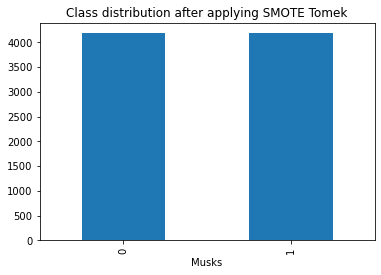

In [12]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Musks')

### Models - CM, max intervals = 6

In [13]:
# ID3 - Default
model = 'ID3'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 6'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
obj = sio.dump(model_id3, model_name)

In [14]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 6'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

musk_CNB_CM_6.sav


['musk_CNB_CM_6.sav']

In [15]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 6'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

musk_KNN-Hamming_CM_6.skops


## 1.2 ChiMerge, max interval = 8

### Data prep

In [16]:
# Complete code for data preperation
# Read data
df_cm2 = pd.read_csv('sc_cm_musk_8int.csv')
df_cm2.rename(columns={'class':'label'}, inplace=True)
disc = 'CM'
k = 8

df_cm2.info()
data = df_cm2.values
data.shape

features = df_cm2.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_cm2[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 167 entries, f1 to label
dtypes: int64(167)
memory usage: 8.4 MB
(6598, 166) (6598,)
Class representation - original:  Counter({0: 5581, 1: 1017})
Class representation - training data:  Counter({0: 4185, 1: 763})
Class representation - testing data:  Counter({0: 1396, 1: 254})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Musks'>

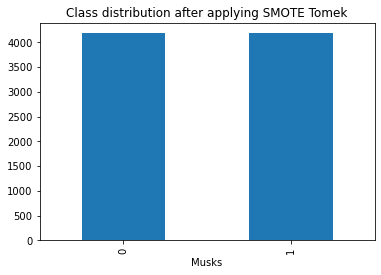

In [17]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Musks')

### Models - ChiMerge, max intervals = 8

In [18]:
# ID3 - Default
model = 'ID3'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 8'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

musk_ID3_CM_8.skops


In [19]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 8'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

musk_CNB_CM_8.sav


['musk_CNB_CM_8.sav']

In [20]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 8'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

musk_KNN-Hamming_CM_8.skops


## 1.3 ChiMerge, max intervals = 10

### Data prep

In [21]:
# Complete code for data preperation
# Read data
df_cm3 = pd.read_csv('sc_cm_musk_10int.csv')
df_cm3.rename(columns={'class':'label'}, inplace=True)
disc = 'cm'
k = 10

df_cm3.info()
data = df_cm3.values
data.shape

features = df_cm3.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_cm3[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 167 entries, f1 to label
dtypes: int64(167)
memory usage: 8.4 MB
(6598, 166) (6598,)
Class representation - original:  Counter({0: 5581, 1: 1017})
Class representation - training data:  Counter({0: 4185, 1: 763})
Class representation - testing data:  Counter({0: 1396, 1: 254})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Musks'>

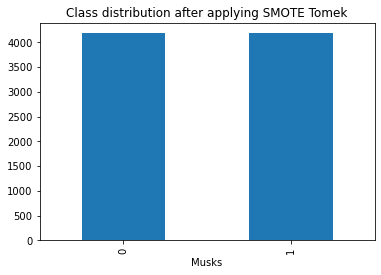

In [22]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Musks')

### Models - ChiMerge, max intervals =10

In [23]:
# ID3 - Default
model = 'ID3'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 10'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

musk_ID3_CM_10.skops


In [24]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 10'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models

import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

musk_CNB_CM_10.sav


['musk_CNB_CM_10.sav']

In [25]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 10'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

musk_KNN-Hamming_CM_10.skops


## 1.4 ChiMerge, max intervals = 15

### Data prep

In [26]:
# Complete code for data preperation
# Read data
df_cm4 = pd.read_csv('sc_cm_musk_15int.csv')
df_cm4.rename(columns={'class':'label'}, inplace=True)
disc = 'cm'
k = 15

df_cm4.info()
data = df_cm4.values
data.shape

features = df_cm4.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify=Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_cm4[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 167 entries, f1 to label
dtypes: int64(167)
memory usage: 8.4 MB
(6598, 166) (6598,)
Class representation - original:  Counter({0: 5581, 1: 1017})
Class representation - training data:  Counter({0: 4185, 1: 763})
Class representation - testing data:  Counter({0: 1396, 1: 254})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Musks'>

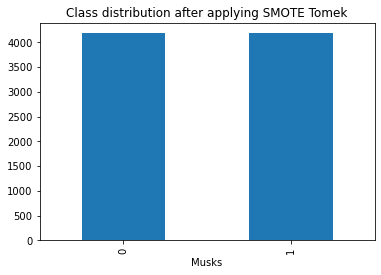

In [27]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Musks')

### Models, ChiMerge, max intervals = 15

In [28]:
# ID3 - Default
model = 'ID3'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 15'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

musk_ID3_CM_15.skops


In [29]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 15'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models

import joblib
filename = f"{dataset}_{model}_{discretizer}_{k}.sav"
print(filename)
joblib.dump(model_nb, filename)

musk_CNB_CM_15.sav


['musk_CNB_CM_15.sav']

In [30]:
# Knn-Hammingcomplete code

model = 'KNN-Hamming'
dataset = 'musk'
discretizer = 'CM'
disc_param = 'k = 15'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, k = {k} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{k}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

musk_KNN-Hamming_CM_15.skops


# 2. Decision Tree Discretizer

## 2.1 DT, max_depth = 2

### Data prep

In [31]:
# Complete code for data preperation
# Read data
df_dt1 = pd.read_csv('DT_small_discretized_musk.csv')
df_dt1.rename(columns={'class':'label'}, inplace=True)
disc = 'DT'
max_depth = 2

df_dt1.info()
data = df_dt1.values
data.shape

features = df_dt1.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_dt1[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 169 entries, molecule_name to label
dtypes: int64(169)
memory usage: 8.5 MB
(6598, 168) (6598,)
Class representation - original:  Counter({0: 5581, 1: 1017})
Class representation - training data:  Counter({0: 4185, 1: 763})
Class representation - testing data:  Counter({0: 1396, 1: 254})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Musks'>

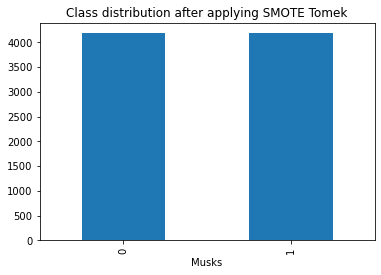

In [32]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Musks')

### Models - DT, max_depth = 2

In [33]:
# ID3 - Default
model = 'ID3'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 2'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

musk_ID3_DT_2.skops


In [34]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 2'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{max_depth}.sav"
print(filename)
joblib.dump(model_nb, filename)

musk_CNB_DT_2.sav


['musk_CNB_DT_2.sav']

In [35]:
# Knn-Hamming complete code

model = 'KNN-Hamming'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 2'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

musk_KNN-Hamming_DT_2.skops


## 2.2 Decision Tree, max_depth = 3

### Data prep

In [36]:
# Complete code for data preperation
# Read data
df_dt2 = pd.read_csv('DT_medium_discretized_musk.csv')
df_dt2.rename(columns={'class':'label'}, inplace=True)
disc = 'DT'
max_depth = 3

df_dt2.info()
data = df_dt2.values
data.shape

features = df_dt2.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_dt2[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 169 entries, molecule_name to label
dtypes: int64(169)
memory usage: 8.5 MB
(6598, 168) (6598,)
Class representation - original:  Counter({0: 5581, 1: 1017})
Class representation - training data:  Counter({0: 4185, 1: 763})
Class representation - testing data:  Counter({0: 1396, 1: 254})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Musks'>

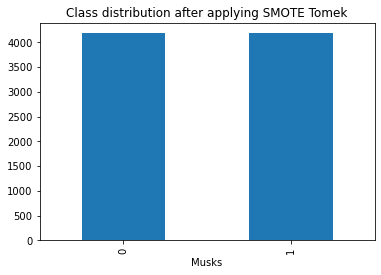

In [37]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Musks')

### Models, DT, max_depth = 3

In [38]:
# ID3 - Default
model = 'ID3'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 3'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

musk_ID3_DT_3.skops


In [39]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 3'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{max_depth}.sav"
print(filename)
joblib.dump(model_nb, filename)

musk_CNB_DT_3.sav


['musk_CNB_DT_3.sav']

In [40]:
# Knn-Hamming complete code

model = 'KNN-Hamming'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 3'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

musk_KNN-Hamming_DT_3.skops


## 2.3 Decision Tree, max_depth = 4

### Dataprep

In [41]:
# Complete code for data preperation
# Read data
df_dt3 = pd.read_csv('DT_large_discretized_musk.csv')
df_dt3.rename(columns={'class':'label'}, inplace=True)
disc = 'DT'
max_depth = 4

df_dt3.info()
data = df_dt3.values
data.shape

features = df_dt3.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_dt3[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 169 entries, molecule_name to label
dtypes: int64(169)
memory usage: 8.5 MB
(6598, 168) (6598,)
Class representation - original:  Counter({0: 5581, 1: 1017})
Class representation - training data:  Counter({0: 4185, 1: 763})
Class representation - testing data:  Counter({0: 1396, 1: 254})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Musks'>

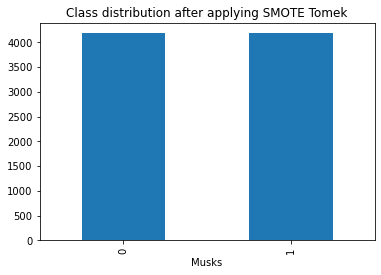

In [42]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Musks')

### Models, DT, max_depth = 4

In [43]:
# ID3 - Default
model = 'ID3'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 4'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

musk_ID3_DT_4.skops


In [44]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 4'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{max_depth}.sav"
print(filename)
joblib.dump(model_nb, filename)

musk_CNB_DT_4.sav


['musk_CNB_DT_4.sav']

In [45]:
# Knn-Hamming complete code

model = 'KNN-Hamming'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 4'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

musk_KNN-Hamming_DT_4.skops


## 2.3 Decision Tree, max_depth = 5

### Data prep

In [46]:
# Complete code for data preperation
# Read data
df_dt4 = pd.read_csv('DT_verylarge_discretized_musk.csv')
df_dt4.rename(columns={'class':'label'}, inplace=True)
disc = 'DT'
max_depth = 5

df_dt4.info()
data = df_dt4.values
data.shape

features = df_dt4.drop('label', axis = 1).columns

# separate the data into X and y
X = data[:, : len(features)]
Y = data[:,-1]

print(X.shape, Y.shape)

# Split train test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state = 30, stratify = Y)

# Check representation of class
print('Class representation - original: ', Counter(Y)) 
print('Class representation - training data: ', Counter(y_train)) 
print('Class representation - testing data: ', Counter(y_test)) 

# Check number of categories for features
n_categories = df_dt4[features].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6598 entries, 0 to 6597
Columns: 169 entries, molecule_name to label
dtypes: int64(169)
memory usage: 8.5 MB
(6598, 168) (6598,)
Class representation - original:  Counter({0: 5581, 1: 1017})
Class representation - training data:  Counter({0: 4185, 1: 763})
Class representation - testing data:  Counter({0: 1396, 1: 254})


<AxesSubplot:title={'center':'Class distribution after applying SMOTE Tomek'}, xlabel='Musks'>

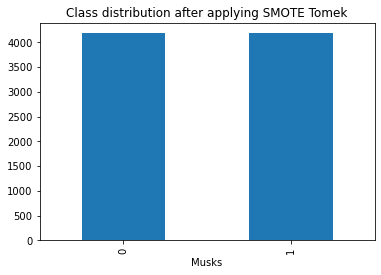

In [47]:
from imblearn.combine import SMOTETomek
smt_tomek = SMOTETomek(random_state=42)
x_resample, y_resample = smt_tomek.fit_resample(x_train, y_train)
# Check labels in traning dataset after SMOTE
pd.Series(y_resample) \
.value_counts() \
.plot(kind='bar', title='Class distribution after applying SMOTE Tomek', xlabel='Musks')

### Models, DT, max_depth = 5

In [48]:
# ID3 - Default
model = 'ID3'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 5'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_id3 = Id3Estimator()
model_id3.fit(x_resample, y_resample)

# Testing
y_pred_id3 = model_id3.predict(x_test)
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_id3), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_id3),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(model_id3, model_name)

musk_ID3_DT_5.skops


In [49]:
# Naive Bayes - pass number of categories in min_categories
model = 'CNB'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 5'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

model_nb = CategoricalNB(min_categories = n_categories)
model_nb.fit(x_resample, y_resample)

# Testing
y_pred_nb = model_nb.predict(x_test)
model_nb.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_nb), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_nb),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import joblib
filename = f"{dataset}_{model}_{discretizer}_{max_depth}.sav"
print(filename)
joblib.dump(model_nb, filename)

musk_CNB_DT_5.sav


['musk_CNB_DT_5.sav']

In [50]:
# Knn-Hamming complete code

model = 'KNN-Hamming'
dataset = 'musk'
discretizer = 'DT'
disc_param = 'max_depth = 5'

f = open("musk_supervised_disc_models.txt", "a")
import time
start = time.time() # For measuring time execution

# Knn-Hamming complete code
knn_hamming = KNeighborsClassifier(n_neighbors=3, metric='hamming', algorithm='auto')
knn_hamming.fit(x_resample, y_resample)

# Testing
y_pred_knn = knn_hamming.predict(x_test)
knn_hamming.classes_
print(f'Models results: model {model}, dataset {dataset}, discretization {discretizer} with parameter {disc_param}', 
      file = f)
print('Classification report', file = f)
print(classification_report(y_test, y_pred_knn), file = f)

from imblearn.metrics import geometric_mean_score as gmean
print('G-mean:', gmean(y_test, y_pred_knn),file = f)

end = time.time()
print(f'Time for training model {model}- default, {disc}, max_depth = {max_depth} is: {end - start}.', file = f) # Total time execution
print('=='*20, file = f)
f.close()

# Save models
import skops.io as sio
model_name = f"{dataset}_{model}_{discretizer}_{max_depth}.skops"
print(model_name)
obj = sio.dump(knn_hamming, model_name)

musk_KNN-Hamming_DT_5.skops
